In [1]:
from utils import *

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [168]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(50, 'relu')
        self.V = tf.keras.layers.Dense(1)
        self.P = tf.keras.layers.Dense(A, 'softmax')
        self.build((None,S))
    
    def call(self, x):
        x = self.W1(x)
        x = self.W2(x)
        return self.P(x), tf.squeeze(self.V(x))
    
create_nn = lambda S,A: Model(S,A)

In [218]:
_min, clip, log = tf.minimum, tf.clip_by_value, tf.math.log
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.nn = create_nn(S,A)
        self.D = deque(maxlen=3000) # save all transitions
        
    def first_step(self, s, sdict): # [S]
        P, V = self.nn(s[None,:]) # [1,A], []
        A = tf.random.categorical(tf.math.log(P), num_samples=1) # [1,1]
        a = int(A[0,0]) # []
        self.E = []
        self.s, self.a, self.pi = s, a, P[0,a] # save prev state + action
        sdict['entropy'] += 0
        return a
        
    def step(self, r, s, sdict): # [], [S]
        # append tuple to experience replay
        self.E.append([self.s, self.a, self.pi, r, s]) # s, a, pi, r, s'
        P, V = self.nn(s[None,:]) # [1,A], []
        sdict['entropy'] += float( -tf.reduce_sum(P * tf.math.log(P)) )
        A = tf.random.categorical(tf.math.log(P), num_samples=1) # [1,1]
        a = int(A[0,0]) # []
        self.s, self.a, self.pi = s, a, P[0,a] # save previous state, action
        return a
    
    def last_step(self, r, sdict):
        self.E.append([self.s, self.a, self.pi, r, None]) # s, a, pi, r, s'
        # prerprocess reward
        R = np_map(lambda x: x[3], self.E) # [e]
        G = discount_rewards(R, self.y, normalize=True) # [e]
        for i,_ in enumerate(self.E): self.E[i][3] = G[i]
        # extend D (data) w/ E (episode data)
        self.D.extend(self.E)
        # train nn for 1 epoch on D 
        S,A,P_old,G = [np_map(lambda x: x[j], self.D) for j in range(4)] # [b,S], [b], [b], [b]
        with tf.GradientTape() as tape:
            P, V = self.nn(S) # [b,A], [b]
            P = pick_action_values(P, A) # [b]
            Adv = tf.stop_gradient(G - V) # [b] (advantage)
            policy_loss = ppo1(P, P_old, Adv) # [b]
            entropy = - P * tf.math.log(P) # [b]
            value_loss = (G - V)**2 # [b]
            loss = policy_loss - 0.01*entropy + 0.5*value_loss # [b]
            loss = tf.reduce_mean(loss) # avg of all examples
        # calc + update gradients
        nn_vars = self.nn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))

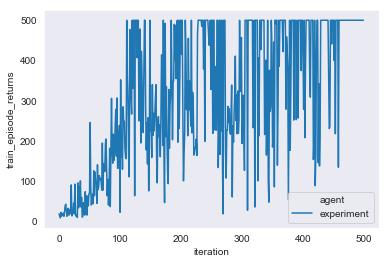

In [219]:
exp = Experiment(env, agent_fn(S,A))
df = exp.run(500,1)
plot_df(df)

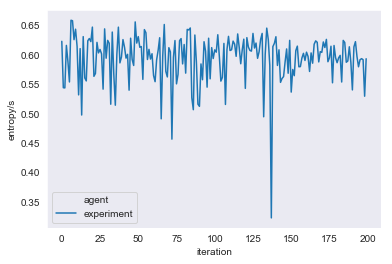

In [214]:
plot_df(df, y='entropy/s')

In [ ]:
P = np.array([[0.3,0.2,0.5]])
tf.random.categorical(tf.math.log(P), num_samples=1)

In [143]:
_min, clip, log = tf.minimum, tf.clip_by_value, tf.math.log
def ppo1(P_new, P_old, Adv, e=0.2): # [b], [b], [b], []
    # ratio=pi/pi_old, Advantage=G-V, Action that was taken (one-hot), epsilon
    r = P_new/P_old # = tf.exp( log(A_hat) - log(A_old) ) # [e,A]
    return - _min( r*Adv, clip(r,1-e,1+e)*Adv )

In [144]:
def ppo2(P_new, P_old, Adv, e=0.2): # [b,A], [b,1], [b,A], []
    # ratio=pi/pi_old, Advantage=G-V, Action that was taken (one-hot), epsilon
    r = P_new/P_old # = tf.exp( log(A_hat) - log(A_old) ) # [e,A]
    return - _min( r*Adv, tf.where(Adv>0, (1+e)*Adv, (1-e)*Adv) )

In [189]:
agent_fn = lambda S,A: Agent(S, A, lr=1e-2, gamma=0.99)

In [190]:
exp = Experiment(env, agent_fn(S,A))
df = exp.run(500,1)
plot_df(df)

KeyboardInterrupt: 

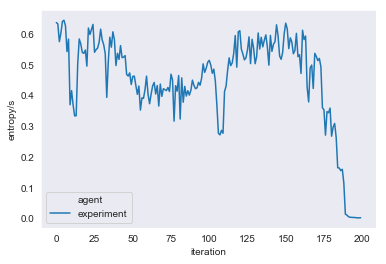

In [105]:
plot_df(df, y='entropy/s')

In [160]:
exp.show_play()

101

In [55]:
agent_fn = lambda S,A,env_fn=None: Agent(S, A, ppo_fn=ppo1, lr=1e-2, gamma=0.99)
test_agent_on_simple_games(agent_fn, 'PPO', game_dict={'CartPole-v1':500})

True

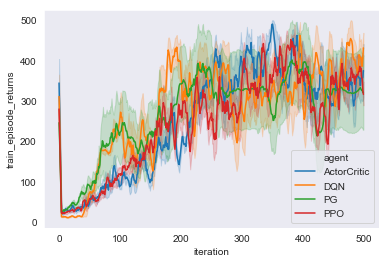

In [133]:
df = load_my_benchmark('CartPole-v1')
plot_df(df, rolling_mean=5)